In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


###Demonstrate using the simulator for a deterministic surface simulation with SEEG monitor 
integration.

``Run time``: approximately 27 seconds (workstation circa 2010).
``Memory requirement``: ~ 1 GB

In [2]:
from tvb.datatypes.cortex import Cortex

from tvb.simulator.lab import *

In [3]:
LOG.info("Configuring...")

In [4]:
#Initialise a Model, Coupling, and Connectivity.

sens = sensors.SensorsInternal(load_default=True)

oscillator = models.Generic2dOscillator()
white_matter = connectivity.Connectivity(load_default=True)
white_matter.speed = numpy.array([4.0])

white_matter_coupling = coupling.Linear(a=0.014)


In [5]:
#Initialise an Integrator
heunint = integrators.HeunDeterministic(dt=2 ** -4)

In [6]:
#Initialise some Monitors with period in physical time
mon_tavg = monitors.TemporalAverage(period=2 ** -2)
mon_savg = monitors.SpatialAverage(period=2 ** -2)

# load the default region mapping
rm = region_mapping.RegionMapping(load_default=True)
#Initialise some Monitors with period in physical time
mon_eeg = monitors.EEG(load_default=True,
                       region_mapping=rm,
                       period=2 ** -2) 
mon_seeg = monitors.iEEG(load_default=True,
                         region_mapping=rm,
                         period=2 ** -2)

In [7]:
#Bundle them
what_to_watch = (mon_tavg, mon_savg, mon_eeg, mon_seeg)


In [8]:
#Initialise a surface
local_coupling_strength = numpy.array([2 ** -10])
default_cortex = Cortex(load_default=True)
default_cortex.coupling_strength = local_coupling_strength

In [9]:
#Initialise Simulator -- Model, Connectivity, Integrator, Monitors, and surface.
sim = simulator.Simulator(model=oscillator, connectivity=white_matter,
                          coupling=white_matter_coupling,
                          integrator=heunint, monitors=what_to_watch,
                          surface=default_cortex)
sim.configure()


Simulator(bound=False, value=None)

In [10]:
#Perform the simulation
tavg_data = []
tavg_time = []
savg_data = []
savg_time = []
eeg_data = []
eeg_time = []
seeg_data = []
seeg_time = []

for tavg, savg, eeg, seeg in sim(simulation_length=2 ** 2):

    if not tavg is None:
        tavg_time.append(tavg[0])
        tavg_data.append(tavg[1])

    if not savg is None:
        savg_time.append(savg[0])
        savg_data.append(savg[1])

    if not eeg is None:
        eeg_time.append(eeg[0])
        eeg_data.append(eeg[1])
    if not seeg is None:
        seeg_time.append(seeg[0])
        seeg_data.append(seeg[1])

LOG.info("finished simulation.")

####Plot pretty pictures of what we just did  

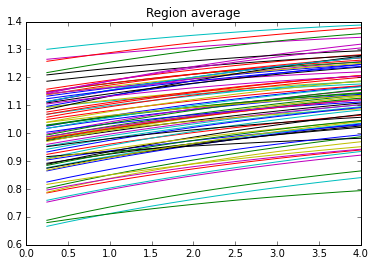

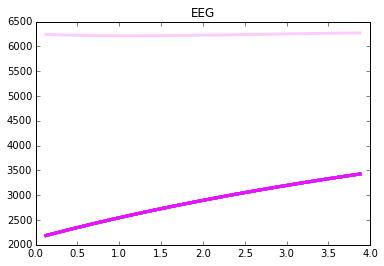

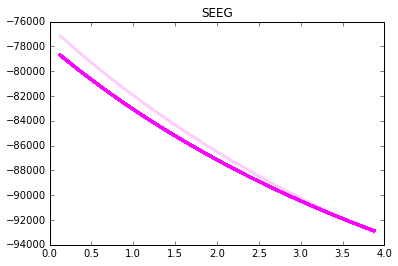

In [11]:
#Make the lists numpy.arrays for easier use.
TAVG = numpy.array(tavg_data)
SAVG = numpy.array(savg_data)
EEG = numpy.array(eeg_data)
SEEG = numpy.array(seeg_data)

#Plot region averaged time series
figure(3)
plot(savg_time, SAVG[:, 0, :, 0])
title("Region average")


#Plot EEG time series
figure(4)
color_idx = numpy.linspace(0, 1, EEG.shape[2])
for i in color_idx:
    plot(eeg_time, EEG[:, 0, i, 0], color=cm.cool(i), lw=3, alpha=0.2)
title("EEG")

#Plot SEEG time series
figure(5)
color_idx = numpy.linspace(0, 1, SEEG.shape[2])
for i in color_idx:
    plot(seeg_time, SEEG[:, 0, i, 0], color=cm.cool(i), lw=3, alpha=0.2)
title("SEEG")

#Show them
show()



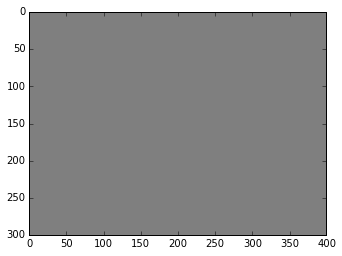

In [12]:
#Surface movie, requires mayavi.mlab
if IMPORTED_MAYAVI:
    from tvb.simulator.plot.tools import mlab
    st = surface_timeseries(sim.surface, TAVG[:, 0, :, 0])
    imshow(mlab.screenshot())